# Laboratorio 6 - Análisis de Redes sociales

### Sebastian Juarez - 21471
### Juan Pablo Cordón - 21458

Link al repositorio de Github: https://github.com/SebasJuarez/DS-Collection/tree/Lab6

## Avances

### Imports

In [ ]:
import json, re, ast, sys, math, unicodedata
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

nltk.download("stopwords")
DATA_PATH = Path("./Data/tioberny.txt")

stopwords = nltk.corpus.stopwords.words("spanish")

URL_RE   = re.compile(r"https?://\S+|www\.\S+")
MENT_RE  = re.compile(r"@\w+")
HASH_RE  = re.compile(r"#\w+")
PUNC_RE  = re.compile(r"[^\w\sáéíóúüñ]")
MULTISPC = re.compile(r"\s+")
EMOJI_RANGES = [
    (0x1F300, 0x1FAD6), (0x1F600, 0x1F64F), (0x2700, 0x27BF),
    (0x1F900, 0x1F9FF), (0x1FA70, 0x1FAFF)
]
def strip_emojis(s: str) -> str:
    return "".join(ch for ch in s if not any(a<=ord(ch)<=b for a,b in EMOJI_RANGES))

def normalize_user(u):
    if pd.isna(u): return None
    u = str(u).strip()
    u = u[1:] if u.startswith("@") else u
    return u.lower()

def clean_text(s,
               to_lower=True,
               remove_urls=True,
               remove_hashtags=True,
               remove_mentions=True,
               remove_punct=True,
               remove_numbers=False,
               remove_emojis=True,
               remove_stopwords=True,
               keep_exclaim_question=True):
    if s is None: return ""
    t = str(s)
    if to_lower: t = t.lower()
    if remove_urls: t = URL_RE.sub(" ", t)
    if remove_hashtags: t = HASH_RE.sub(" ", t)
    if remove_mentions: t = MENT_RE.sub(" ", t)
    if remove_emojis: t = strip_emojis(t)
    # Mantenemos ! y ? para el analisis de sentimientos
    if remove_punct:
        if keep_exclaim_question:
            t = re.sub(r"[^\w\sáéíóúüñ!?]", " ", t)
        else:
            t = PUNC_RE.sub(" ", t)
    
    if remove_numbers: t = re.sub(r"\d+", " ", t)
    t = MULTISPC.sub(" ", t).strip()
    if remove_stopwords:
        t = " ".join(w for w in t.split() if w not in stopwords)
    return t



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importar los datos de txt

In [ ]:
from pathlib import Path
import json, ast, re
import pandas as pd

def sniff_encoding(path: Path) -> str:
    with path.open("rb") as fb:
        head = fb.read(4)
    if head.startswith(b"\xff\xfe") or head.startswith(b"\xfe\xff"):
        return "utf-16"
    if head.startswith(b"\xef\xbb\xbf"):
        return "utf-8-sig"
    return "utf-8"

def try_load(DATA_PATH: Path) -> pd.DataFrame:
    if not DATA_PATH.exists():
        raise FileNotFoundError(f"No existe: {DATA_PATH.resolve()}")

    enc = sniff_encoding(DATA_PATH)

    # JSONS
    try:
        records = []
        with DATA_PATH.open("r", encoding=enc, errors="strict", newline="") as f:
            first = f.read(1)
            rest  = f.read()
            content = (first or "") + rest
        content = content.strip()

        if content.startswith("[") and content.endswith("]"):
            records = json.loads(content)
        else:
            records = []
            for ln in content.splitlines():
                s = ln.strip()
                if not s or not s.startswith("{"):
                    continue
                try:
                    records.append(json.loads(s))
                except json.JSONDecodeError:
                    continue

        if records:
            df = pd.json_normalize(records)
        else:
            raise ValueError("No se detectó JSON válido.")
    except Exception:
        # CSVs
        try:
            df = pd.read_csv(DATA_PATH, encoding=enc, on_bad_lines="skip")
        except UnicodeDecodeError:
            df = pd.read_csv(DATA_PATH, encoding="latin-1", on_bad_lines="skip")
        except Exception:
            # TXTs como jsons
            records = []
            with DATA_PATH.open("r", encoding=enc, errors="ignore") as f:
                for ln in f:
                    s = ln.strip()
                    if not s: 
                        continue
                    try:
                        obj = ast.literal_eval(s)
                        records.append(obj)
                    except Exception:
                        pass
            if not records:
                raise
            df = pd.json_normalize(records)

    # Tomamos las columnas
    def pick(cols):
        for c in cols:
            if c in df.columns: return c
        return None

    id_col   = pick(["id","id_str","tweet.id","conversationId","conversationIdStr"])
    text_col = pick(["text","rawContent","full_text","tweet.text"])
    dt_col   = pick(["created_at","date","tweet.created_at"])
    user_col = pick(["user.screen_name","user.username","user.name","username","user"])
    uid_col  = pick(["user.id","user.id_str","userId","user.id_str"])
    reply_to = pick(["in_reply_to_screen_name","inReplyToUser","in_reply_to_user","inReplyToUsername"])
    rt_of    = pick(["retweeted_status.user.screen_name","retweeted_user","retweet_of"])
    like_c   = pick(["favorite_count","likeCount","tweet.favorite_count"])
    rt_c     = pick(["retweet_count","retweetCount","tweet.retweet_count"])
    ment_col = pick(["entities.user_mentions","mentionedUsers","mentions"])

    out = pd.DataFrame({
        "id": df.get(id_col),
        "created_at": df.get(dt_col),
        "user_id": df.get(uid_col),
        "username": df.get(user_col),
        "text": df.get(text_col),
        "in_reply_to": df.get(reply_to),
        "retweet_of": df.get(rt_of),
        "like_count": df.get(like_c),
        "rt_count": df.get(rt_c),
        "mentions_raw": df.get(ment_col),
        "raw": df.to_dict(orient="records")
    })

    def normalize_user(u):
        if pd.isna(u): return None
        u = str(u).strip()
        u = u[1:] if u.startswith("@") else u
        return u.lower()

    def to_mention_list(x):
        if isinstance(x, list):
            m = []
            for it in x:
                if isinstance(it, dict):
                    val = it.get("username") or it.get("screen_name")
                    if val: m.append(normalize_user(val))
                else:
                    m.append(normalize_user(it))
            return m
        import re
        MENT_RE = re.compile(r"@\w+")
        return [normalize_user(m) for m in MENT_RE.findall(str(x))] if pd.notna(x) else []

    out["username"]    = out["username"].map(normalize_user)
    out["in_reply_to"] = out["in_reply_to"].map(normalize_user)
    out["retweet_of"]  = out["retweet_of"].map(normalize_user)
    out["mentions"]    = out["mentions_raw"].apply(to_mention_list)

    return out

# Pequeña visualización
tweets = try_load(DATA_PATH)
print("Shape:", tweets.shape)
tweets.head(3)


Shape: (5019, 12)


,id,created_at,user_id,username,text,in_reply_to,retweet_of,like_count,rt_count,mentions_raw,raw,mentions
0,1834281080029110288,2024-09-12 17:21:03+00:00,1435062946598694914,la_revoluzzion,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",None,None,0,0,"[{'id': 23664866, 'id_str': '23664866', 'usern...","{'id': 1834281080029110288, 'id_str': '1834281...","[usembassyguate, 48cantonestoto, usaidguate, u..."
1,1834252464092069901,2024-09-12 15:27:20+00:00,956650778634145792,xelanewsgt,#URGENTE Lo que los medios #faferos no informa...,None,None,142,80,[],"{'id': 1834252464092069901, 'id_str': '1834252...",[]
2,1834280919336976681,2024-09-12 17:20:25+00:00,1087057038755143680,m24095273,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,None,None,0,0,"[{'id': 77653794, 'id_str': '77653794', 'usern...","{'id': 1834280919336976681, 'id_str': '1834280...","[ivanduque, barevalodeleon]"


### Limpieza ajustable de simbolos y stopwords

In [ ]:
CFG = dict(
    to_lower=True,
    remove_urls=True,
    remove_hashtags=True,
    remove_mentions=True,
    remove_punct=True,
    remove_numbers=False,
    remove_emojis=True,
    remove_stopwords=True
)

tweets["text_clean"] = tweets["text"].apply(lambda s: clean_text(s, **CFG))
tweets["len_chars"]  = tweets["text_clean"].str.len()
tweets["n_words"]    = tweets["text_clean"].str.split().str.len()
tweets.sample(5)[["username","text","text_clean","n_words"]]


,username,text,text_clean,n_words
2249,sergioc26844120,@UbaldoMacu @MPguatemala @santipalomov @BAreva...,creen tener micrófono mano pueden soltar cualq...,15
4763,toyita_m,@JosMChacn2 @BArevalodeLeon Y como la Corte In...,corte internacional justicia dice q sionistas ...,30
2243,dvidx84,@GersonGudielCas @BArevalodeLeon Para comenzar...,comenzar señor presidente hoy salió gracias jefes,7
1899,pedrolhernande6,@GersonGudielCas @BArevalodeLeon Definitivamen...,definitivamente cualquiera estuvieramos mejor,4
2172,pajarit92336502,@MendiaMariela @BArevalodeLeon El estado falli...,estado fallido ha hecho èl,5


### Duplicados

In [ ]:
tweets = tweets.drop_duplicates(subset=["id"]).copy()
tweets = tweets.drop_duplicates(subset=["text_clean"]).copy()

tweets["username"] = tweets["username"].map(normalize_user)
tweets["mentions"] = tweets["mentions"].apply(lambda L: [normalize_user(u) for u in (L or []) if u])


In [33]:
EDGE_ROWS = []

for _, r in tweets.iterrows():
    author = r["username"]
    if not author: 
        continue

    # MENCIONES: author --> mentioned
    for m in (r["mentions"] or []):
        if m and m != author:
            EDGE_ROWS.append({"src": author, "dst": m, "type": "mention", "tweet_id": r["id"]})

    # RESPUESTAS: author --> in_reply_to
    if pd.notna(r.get("in_reply_to")) and r["in_reply_to"] and r["in_reply_to"] != author:
        EDGE_ROWS.append({"src": author, "dst": r["in_reply_to"], "type": "reply", "tweet_id": r["id"]})

    # RETWEETS: author --> usuario original
    if pd.notna(r.get("retweet_of")) and r["retweet_of"] and r["retweet_of"] != author:
        EDGE_ROWS.append({"src": author, "dst": r["retweet_of"], "type": "retweet", "tweet_id": r["id"]})

edges = pd.DataFrame(EDGE_ROWS)
print(edges.type.value_counts(dropna=False))
edges.head(10)


type
mention    15468
Name: count, dtype: int64


,src,dst,type,tweet_id
0,la_revoluzzion,usembassyguate,mention,1834281080029110288
1,la_revoluzzion,48cantonestoto,mention,1834281080029110288
2,la_revoluzzion,usaidguate,mention,1834281080029110288
3,la_revoluzzion,ueguatemala,mention,1834281080029110288
4,la_revoluzzion,barevalodeleon,mention,1834281080029110288
5,m24095273,ivanduque,mention,1834280919336976681
6,m24095273,barevalodeleon,mention,1834280919336976681
7,carlosalbesc,ivanduque,mention,1834280512933732694
8,carlosalbesc,barevalodeleon,mention,1834280512933732694
9,brenda_agn,barevalodeleon,mention,1834279986254987428


In [ ]:
print("edges shape:", edges.shape)
print("types:", edges["type"].value_counts(dropna=False))

print("\nMuestra de edges:")
display(edges.sample(min(10, len(edges)))[["src","dst","type"]])

print("\nNulos en src/dst/type:",
      edges["src"].isna().sum(),
      edges["dst"].isna().sum(),
      edges["type"].isna().sum())


edges shape: (15468, 4)
types: type
mention    15468
Name: count, dtype: int64

Muestra de edges:


,src,dst,type
2322,pablitomrls,guatemalagob,mention
4971,gtkaliman,_spguatemala,mention
2404,lesslie_860,fjimenezmingob,mention
11409,snakecancelable,elrosaenverdese,mention
4519,leomarksal,barevalodeleon,mention
13122,vequedeahuevo,barevalodeleon,mention
11122,lpez4edwin,barevalodeleon,mention
10505,esilvar2,felixsinexcusas,mention
10076,wichomarg,santipalomov,mention
8111,elrevoltijogt,blancaalfaropc,mention



Nulos en src/dst/type: 0 0 0


### Construcción de la Adyacencia

In [ ]:
adj_total_df = edges.pivot_table(index="src", columns="dst", values="tweet_id",
                                 aggfunc="count", fill_value=0)

users = sorted(set(adj_total_df.index).union(set(adj_total_df.columns)))
adj_total_df = adj_total_df.reindex(index=users, columns=users, fill_value=0)

adj_by_type = {k: g.pivot_table(index="src", columns="dst", values="tweet_id",
                                aggfunc="count", fill_value=0)
               for k, g in edges.groupby("type")}
for k, A in adj_by_type.items():
    adj_by_type[k] = A.reindex(index=users, columns=users, fill_value=0)

A_mention = adj_by_type.get("mention", pd.DataFrame(0, index=users, columns=users)).values
A_reply   = adj_by_type.get("reply",   pd.DataFrame(0, index=users, columns=users)).values
A_retweet = adj_by_type.get("retweet", pd.DataFrame(0, index=users, columns=users)).values


In [30]:
print("Pesos totales:", adj_total_df.values.sum())
print("Top 10 de las cuentas que mas interactuan con las demas:")
display(adj_total_df.sum(axis=1).sort_values(ascending=False).head(10))
print("Top 10 cuentas que mas reciben interacciones:")
display(adj_total_df.sum(axis=0).sort_values(ascending=False).head(10))


Pesos totales: 15468
Top 10 de las cuentas que mas interactuan con las demas:


user
elrevoltijogt      197
alejand09098718    118
ialmgg              92
leraovalle          81
mendiamariela       76
diariodeca          74
gilrey422483        73
billyc2023          73
edwadriperez        66
johanmauricio34     65
dtype: int64

Top 10 cuentas que mas reciben interacciones:


user
barevalodeleon    4349
guatemalagob       813
ubaldomacu         532
santipalomov       482
mpguatemala        428
fjimenezmingob     363
__vadertg          252
mingobguate        251
congresoguate      234
usaidguate         197
dtype: int64

### Grafo interactivo en HTML (Datos completos)

In [ ]:
import networkx as nx
try:
    from pyvis.network import Network
except ImportError:
    # !pip install pyvis
    from pyvis.network import Network

ego = "barevalodeleon"

ego_edges = edges[(edges["src"] == ego) | (edges["dst"] == ego)]

G = nx.DiGraph()
for _, e in ego_edges.iterrows():
    src, dst, t = e["src"], e["dst"], e["type"]
    if not src or not dst: 
        continue
    if G.has_edge(src, dst):
        G[src][dst]["weight"] += 1
        G[src][dst]["types"].add(t)
    else:
        G.add_edge(src, dst, weight=1, types={t})

net = Network(height="600px", width="100%", directed=True, notebook=True, bgcolor="#222222", font_color="white")

for node in G.nodes():
    size = 20 if node == ego else 10
    color = "red" if node == ego else "lightblue"
    net.add_node(node, label=node, size=size, color=color)

for u, v, data in G.edges(data=True):
    label = ",".join(list(data["types"]))
    net.add_edge(u, v, value=data["weight"], title=f"{label} ({data['weight']})")

net.show("ego_barevalodeleon.html")


### Grafo estático (menos info)

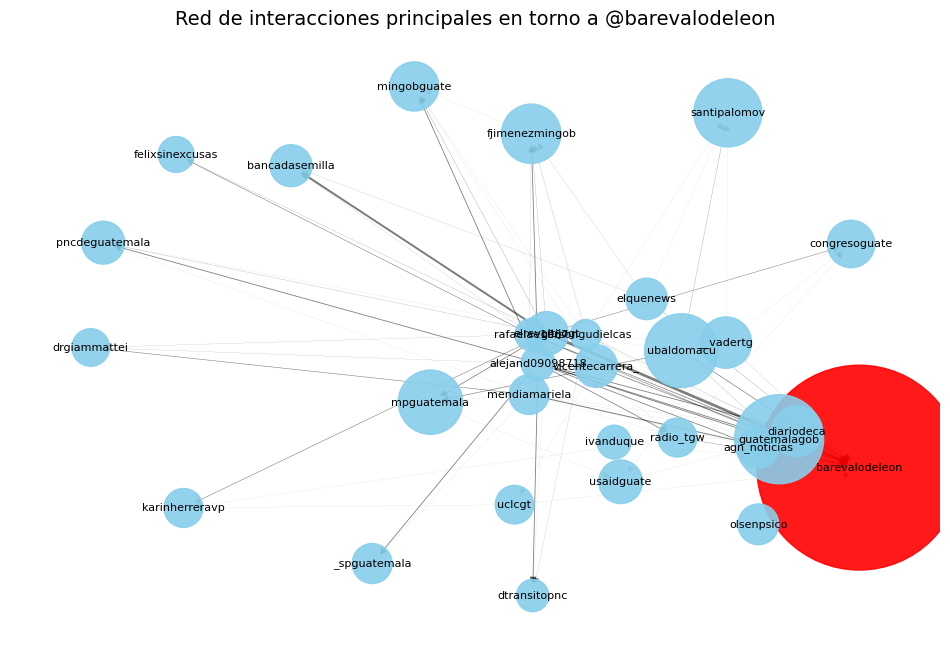

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Usamos los edges filtrados
G = nx.DiGraph()
for _, e in edges.iterrows():
    src, dst, t = e["src"], e["dst"], e["type"]
    if not src or not dst:
        continue
    if G.has_edge(src, dst):
        G[src][dst]["weight"] += 1
        G[src][dst]["types"].add(t)
    else:
        G.add_edge(src, dst, weight=1, types={t})

deg_total = dict(G.degree(weight="weight"))

# top 30 de usuarios que mas interaccionan con Arevalo
top_users = sorted(deg_total, key=deg_total.get, reverse=True)[:30]
H = G.subgraph(top_users).copy()

pos = nx.spring_layout(H, k=0.5, iterations=50, seed=42)

node_sizes = [deg_total[n]*5 for n in H.nodes()]

# Resaltamos a Arevalo
node_colors = ["red" if n=="barevalodeleon" else "skyblue" for n in H.nodes()]

# Grafo
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(H, pos, width=[d["weight"]*0.05 for (_,_,d) in H.edges(data=True)], alpha=0.5, arrows=True)
nx.draw_networkx_labels(H, pos, font_size=8, font_color="black")

plt.title("Red de interacciones principales en torno a @barevalodeleon", fontsize=14)
plt.axis("off")
plt.show()
